## This script loads the previous trained Unet architecture and overlays video stream

In [1]:
#Define custom loss functions
#Load saved model
#Import all scipy, keras and tflow modules
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D,Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from scipy.ndimage.measurements import label
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

#Redefine loss function
smooth = 1.
def IOU_calc_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)    
    return -2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def IOU_calc(y_true, y_pred):
    return -IOU_calc_loss(y_true, y_pred)

from keras.models import load_model
model = load_model('Vehicle_detect_SmallUnet_two.h5', 
                   custom_objects={'IOU_calc_loss': IOU_calc_loss, 'IOU_calc': IOU_calc})

Using TensorFlow backend.


In [23]:
#Draw bounding boxes
def draw_labeled_bboxes(img, nn_labels):
    
    img = np.array(img, dtype=np.uint8)
    
    nn_labels = np.array(255*nn_labels, dtype=np.uint8)
    heatmap = nn_labels[:,:,0]
    #Find all non-zero entries in heatmap and average over 10 frames
    heatmap = smooth_heatmap(heatmap)
    labels = label(heatmap)
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        if ((np.max(nonzeroy)-np.min(nonzeroy)>30) & (np.max(nonzerox)-np.min(nonzerox)>30)):
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image 
            
            area = (bbox[0][0]-bbox[1][0])*(bbox[0][1]-bbox[1][1])
            
            if bbox[0][0] >300 and bbox[0][1]>200 and bbox[1][1]<370 and area>1600:
                cv2.rectangle(img, bbox[0], bbox[1], (0,255,0),4)

    #Return the image
    return img
#Smoothen car detection over 10 frames
next_10_heatmaps = [np.zeros((400, 640))]*3

def smooth_heatmap(heatmap):
    #Make stack global variable
    global next_10_heatmaps
    
    #Remove first frame
    next_10_heatmaps_temp = next_10_heatmaps[1:]
    
    #Add current frame to stack
    next_10_heatmaps_temp.append(heatmap)
    
    #Find average of stack to find persistent hotspots
    next_10_heatmaps = next_10_heatmaps_temp
   
    heatmap = np.mean(next_10_heatmaps,axis=0)
    
    return heatmap

#Video pipeline
def detection_pipeline(img):
    img = cv2.resize(img, (640, 400))
    #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_r = np.asarray(img).reshape(1, 400, 640, 3)
    pred = model.predict(img_r)
    bbox = draw_labeled_bboxes(img, pred[0])
    return bbox

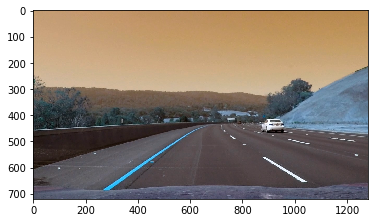

In [24]:
test2 = cv2.imread('test_images/test3.jpg')
draw_test =  detection_pipeline(test2) 
plt.imshow(test2)

In [25]:
#Run pipeline through video stream
from moviepy.editor import VideoFileClip
from IPython.display import HTML
challenge_output = 'project_video_output.mp4'
clip2 = VideoFileClip("project_video.mp4");
white_clip = clip2.fl_image(detection_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(challenge_output, audio=False);

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [01:11<00:00, 16.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 1min 35s, sys: 14.2 s, total: 1min 49s
Wall time: 1min 11s
